# CIFAR-10 Variational Auto-encoder
In this notebook, train a variational auto-encoder with the purpose of later optimizing in the resulting decoder's latent space for feature visualization. I experimented kl annealing to improve reconstruction. The dataset used for training and evaluation is CIFAR-10.

## Setup & Imports
I start by importing PyTorch and other libraries used across the notebook as well as setting a random seed for reproducibility.
The device is set to be 'cuda', if available, for GPU optimization.

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [2]:
import torch
import sklearn
import torchvision.utils as vutils
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

g = torch.Generator()
g.manual_seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Preparation
I load the CIFAR-10 dataset (which is split into 5 files), apply normalization, shuffle the dataset, and split it for training, validation, and testing.

In [3]:
images = np.zeros((5, 10000, 3, 32, 32), dtype=np.float32)
labels = np.zeros((5, 10000), dtype=np.int64)
for i in range(5):
    with open(f"cifar-10-batches-py/data_batch_{i+1}", 'rb') as file:
        data = pickle.load(file, encoding = 'latin1')
        images[i] = np.array(data['data']).reshape(-1, 3, 32, 32) / 255.0
        labels[i] = np.array(data['labels'])


images = images.reshape(-1, 3, 32, 32)
labels = labels.reshape(-1)

# Split the dataset
tr_images, tmp_images, tr_labels, tmp_labels = train_test_split(images, labels, train_size = 0.8, random_state = 42, stratify = labels)
dev_images, tst_images, dev_labels, tst_labels = train_test_split(tmp_images, tmp_labels, train_size = 0.5, random_state = 42, stratify = tmp_labels)

# Convert into torch tensors
tr_images = torch.from_numpy(tr_images).float()
tr_labels = torch.from_numpy(tr_labels)
dev_images = torch.from_numpy(dev_images).float()
dev_labels = torch.from_numpy(dev_labels)
tst_images = torch.from_numpy(tst_images).float()
tst_labels = torch.from_numpy(tst_labels)

# Create a dataloader for training
tr_dataset = torch.utils.data.TensorDataset(tr_images, tr_labels)
tr_dataloader = torch.utils.data.DataLoader(tr_dataset, batch_size = 128, shuffle = True, generator = g)

## Model Architecture
The encoder uses a series of 2 convolutional blocks followed by 1 dense layer without activation.
The decoder uses 1 dense layer followed by a series of 2 upscaling convolutional blocks.


### Convolutional Blocks
Each convolutional block is comprised of a convolutional layer, followed by a ReLu activation, and a max pooling layer for downsampling.
A Batch Normalization layer was later added to improve training stability, which proved effective in terms of achieving higher accuracy.
A Dropout layer was also introduced after observing a discrepancy between training and validation accuracy. The dropout rate was set empirically to 0.2 on the first block, which helped reduce the gap and avoid overfitting, and to 0 on the second block to avoid loss of information in the encoding into the latent space, which proved effective.


### Upscaling Convolutional Blocks
Each convolutional block consists of a transposed convolutional layer, followed by a ReLu activation, for upsampling. A convolutional layer was later added, also followed by a ReLu activation, to improve definition in the reconstruction and avoid tiling, as well as other artifacts.
Other approaches were also attempted, such as using an interpolate layer followed by a convolutional layer, but this resulted in blurriness in the reconstruction and higher reconstruction loss.


## Training Setup
Below, I define the number of epochs, the optimizer, and the loss function.
The number of epochs is set to 50, to achieve a low enough reconstruction loss.
Having in mind that all the data is normalized between 0 and 1, the reconstruction loss selected was Binary Cross Entropy, which, in contrast to Mean Squared Error Loss, doesn't cause as much blurriness (both were experimented with).
The sampling for the VAE is done inside the loop and the KL Divergence Loss is also added to the main loss function, although tuned down to allow for better reconstructions. This, however, has a downside which is that the latent variables are more heavily correlated.

In [4]:
encoder = Encoder(image_size = 32, latent_dim = 512).to(device)
encoder = encoder.to(device)
decoder = Decoder(image_size = 32, latent_dim = 512).to(device)
decoder = decoder.to(device)
epochs = 50
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = 0.001)
criterion = torch.nn.BCELoss()

The following code is a simple training loop that uses the Adam optimizer and tracks the training and the development loss over each epoch.
(It should take around 10 minutes to run on a GPU)


In [5]:
tr_losses = []
kl_losses = []
dev_losses = []

In [6]:

for i in range(epochs):
    encoder.train()
    decoder.train()
    running_loss = 0.0
    running_kl_loss = 0.0
    for j, (batch_in, _) in enumerate(tr_dataloader):
        optimizer.zero_grad()

        batch_in = batch_in.to(device)
        
        encoded = encoder(batch_in)

        split_dim = encoded.shape[-1] // 2
        mean = encoded[:, :split_dim]
        standard_dev = torch.nn.functional.softplus(encoded[:, split_dim:]) + 1e-6
        noise = torch.randn_like(mean)
        x = mean + noise * standard_dev

        batch_out = decoder(x)

        variance = standard_dev ** 2
        kl_loss = -0.5 * torch.sum(1 + torch.log(variance) - mean**2 - variance, dim=1)
        kl_loss = 0.0001 * torch.min(torch.tensor(i / 10), torch.tensor(1.0)) * torch.mean(kl_loss)

        loss = criterion(batch_out, batch_in) + kl_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * batch_in.size(0)
        running_kl_loss += kl_loss.item() * batch_in.size(0)
    
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        batch_in = tst_images.to(device)
        encoded = encoder(batch_in)
        split_dim = encoded.shape[-1] // 2
        mean = encoded[:, :split_dim]
        standard_dev = torch.nn.functional.softplus(encoded[:, split_dim:]) + 1e-6
        noise = torch.zeros_like(mean)
        x = mean + noise * standard_dev
        batch_out = decoder(x)
        dev_loss = criterion(batch_out, batch_in)
        dev_losses.append(dev_loss.item())


    running_loss /= len(tr_dataloader.dataset)
    running_kl_loss /= len(tr_dataloader.dataset)
    tr_losses.append(running_loss)
    kl_losses.append(running_kl_loss)

The graphs below showcase the training and development total loss and kl loss per epoch, which were useful for measuring the performance of the model during the training phase and hyperparameter tuning during development. In addition, they also show the kl loss in proportion to the total loss over the epochs.


               Training       Development    
BCE Loss       0.5693         0.5660         


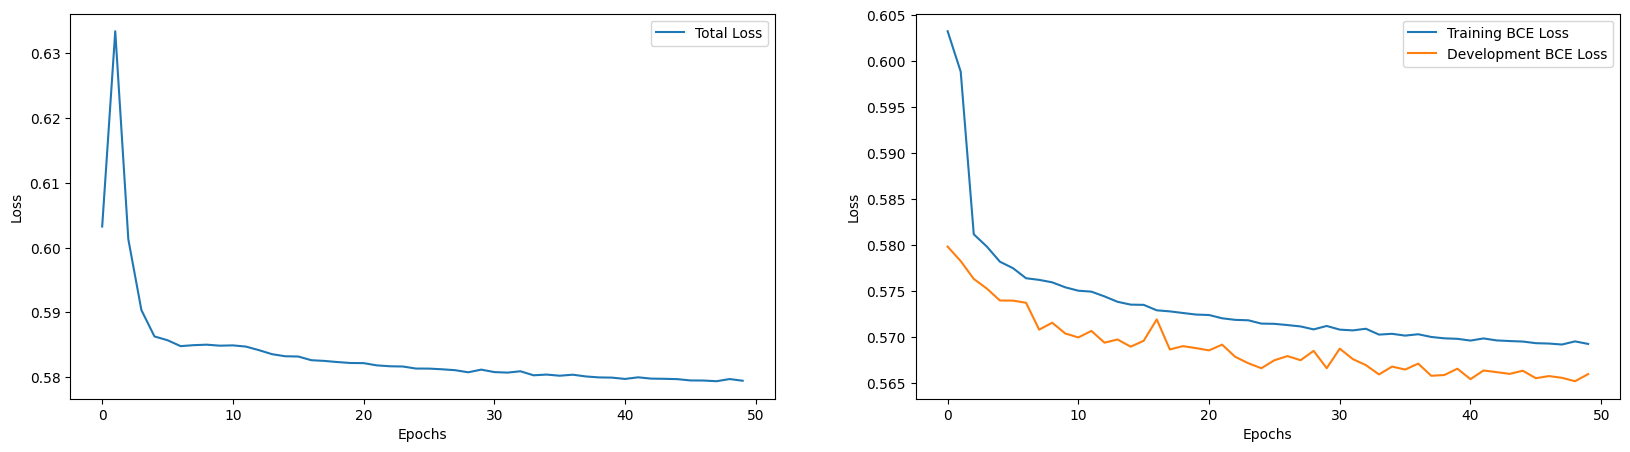

<Figure size 640x480 with 0 Axes>

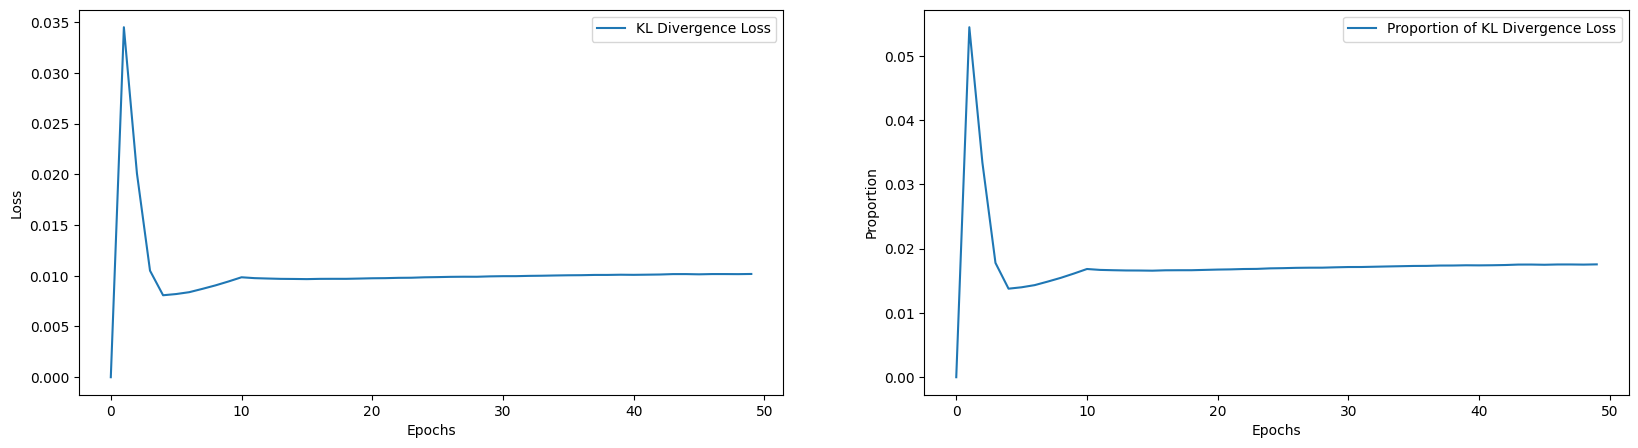

In [7]:
tr_bce_losses = [total - kl for total, kl in zip(tr_losses, kl_losses)]
print(f"\n{'':<15}{'Training':<15}{'Development':<15}")
print(f"{'BCE Loss':<15}{tr_bce_losses[-1]:<15.4f}{dev_losses[-1]:<15.4f}")

training_fig = plt.figure(figsize=(20, 5))

#plot the total loss
training_fig.add_subplot(1, 2, 1)
plt.plot(tr_losses, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#plot the training and development BCE loss
training_fig.add_subplot(1, 2, 2)
plt.plot(tr_bce_losses, label='Training BCE Loss')
plt.plot(dev_losses, label='Development BCE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.clf()

kl_loss_fig = plt.figure(figsize=(20, 5))
#plot the kl loss only
kl_loss_fig.add_subplot(1, 2, 1)
plt.plot(kl_losses, label='KL Divergence Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

#plot the proportion of kl loss to total loss
kl_loss_fig.add_subplot(1, 2, 2)
proportion_kl = [kl / total for kl, total in zip(kl_losses, tr_losses)]
plt.plot(proportion_kl, label='Proportion of KL Divergence Loss')
plt.xlabel('Epochs')
plt.ylabel('Proportion')
plt.legend()
plt.show()

The output of the decoder is visualized below using a grid format. Although the reconstructions are not perfect, they are still overall recognizable, which is sufficient for the purpose of feature visualization.

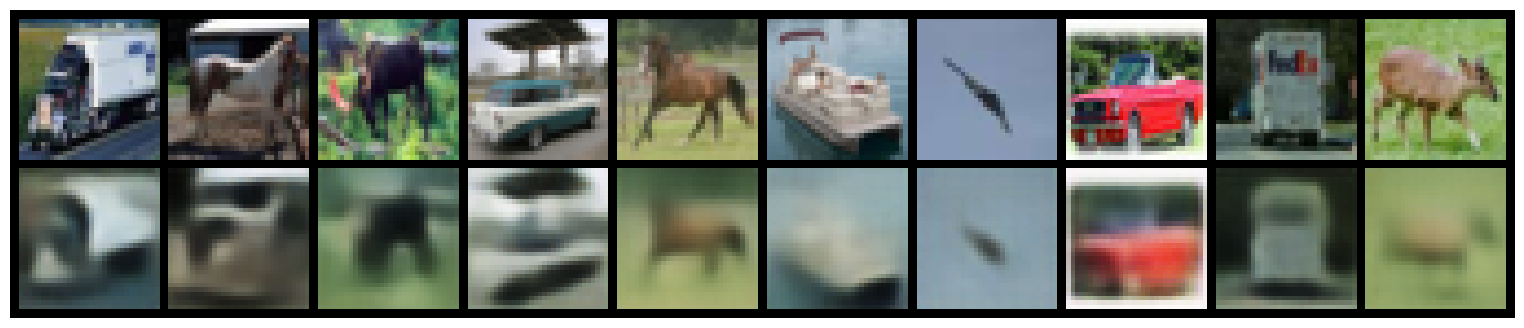

In [8]:
num_images = 10
indices = torch.randperm(tst_images.size(0))[:num_images]
original_images = tst_images[indices].to(device)
reconstructed_images = batch_out[indices].to(device)

plt.figure(figsize=(20, 4))
grid = vutils.make_grid(torch.cat([original_images, reconstructed_images]), nrow=num_images)
plt.imshow(grid.cpu().numpy().transpose(1, 2, 0))
plt.axis("off")
plt.show()

I also plotted the latent space using T-SNE to reduce the dimensionality to 2D for visualization purposes. Each point in the plot represents an image from the test set, colored according to its class label. As can be seen, there is little clustering of the different classes, which is likely due to the low weight of the KL Divergence Loss in the total loss function, which was an option taken as described earlier.

In [9]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(mean.cpu().numpy())

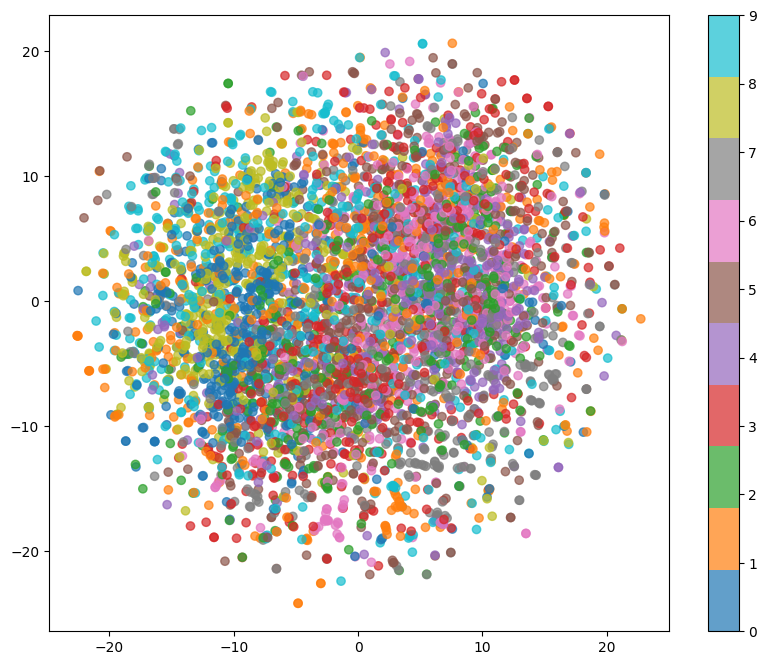

In [10]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=tst_labels.cpu().numpy(), cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.show()

Finally, I compare the loss values for random noise input to the decoder versus actual encoded inputs from the encoder. As expected, the reconstruction loss is significantly higher for random noise inputs, indicating that the decoder has learned to reconstruct images based on meaningful latent representations rather than arbitrary noise.

In [11]:
encoder.eval()
decoder.eval()
with torch.no_grad():
    num_noise = tst_images.size(0)
    noise_input = torch.rand((num_noise, 3, 32, 32), generator=g).to(device)
    encoded_noise = encoder(noise_input)
    split_dim = encoded_noise.shape[-1] // 2
    mean_n = encoded_noise[:, :split_dim]
    std_n = torch.nn.functional.softplus(encoded_noise[:, split_dim:]) + 1e-6
    latent_noise = mean_n + torch.zeros_like(mean_n) * std_n
    recon_noise = decoder(latent_noise)
    tst_loss = criterion(noise_input, recon_noise)

print(f"Noise Loss: {tst_loss.item():.8f}")

Noise Loss: 0.99532354


## Conclusion
The model was able to achieve reasonable performance in reconstruction, with a total of around 13M parameters.

In [12]:
print(f"Encoder Parameters: {round(sum(p.numel() for p in encoder.parameters() if p.requires_grad)/1_000_000, 1)} Million")
print(f"Decoder Parameters: {round(sum(p.numel() for p in decoder.parameters() if p.requires_grad)/1_000_000, 1)} Million")

Encoder Parameters: 8.5 Million
Decoder Parameters: 4.4 Million


In [13]:
# Save the models
torch.save(encoder.state_dict(), "vae_encoder.pth")
torch.save(decoder.state_dict(), "vae_decoder.pth")